In [239]:
# load the change in the files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [240]:
!pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

import numpy as np

## Defining the forward diffusion process


In [241]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

To start with, let's use the linear schedule for \\(T=200\\) time steps and define the various variables from the \\(\beta_t\\) which we will need, such as the cumulative product of the variances \\(\bar{\alpha}_t\\). Each of the variables below are just 1-dimensional tensors, storing values from \\(t\\) to \\(T\\). Importantly, we also define an `extract` function, which will allow us to extract the appropriate \\(t\\) index for a batch of indices.


In [242]:
timesteps = 500

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [243]:
import os
import sys
# append the parent directory to path
sys.path.append('/home/miyen/diffusion-features/diffusion-features')
# sys.path.append('/Users/sagarpatil/sagar/projects/diffusion-features/diffusion-features/')
from utils.get_trajectories import get_trajectories
trajectories = get_trajectories()
trajectories = torch.tensor(trajectories, dtype=torch.float32)
print(trajectories.shape)
x_start = trajectories[30].unsqueeze(0)
x_start = x_start.float()
print(x_start)

/home/miyen/diffusion-features/environment/data/lavaenv
begin pad [[5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0], [5.0, 6.0]]
trajectories [[5.   6.  ]
 [5.25 6.  ]
 [5.5  6.  ]
 [5.75 6.  ]
 [6.   6.  ]
 [6.25 6.  ]
 [6.5  6.  ]
 [6.75 6.  ]
 [7.   6.  ]
 [7.25 6.  ]
 [7.5  6.  ]
 [7.75 6.  ]
 [8.   6.  ]
 [8.   6.25]
 [8.   6.5 ]
 [8.   6.75]
 [8.   7.  ]
 [8.   7.25]
 [8.   7.5 ]
 [8.   7.75]
 [8.   8.  ]]
end pad [[8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0], [8.0, 8.0]]
begin pad [[8.0, 5.0], [8.0, 5.0], [8.0, 5.0], [8.0, 5.0], [8.0, 5.0], [8.0, 5.0], [8.0, 5.0], [8.0, 5.0], [8.0, 5.0], [8

/tmp/ipykernel_1282385/2483978209.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trajectories = torch.tensor(trajectories, dtype=torch.float32)


In [244]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

Let's test it on a particular time step:

In [245]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  # noisy_image = reverse_transform(x_noisy.squeeze())

  return x_noisy

In [246]:
# take time step
t = torch.tensor([40])

x_noisy = get_noisy_image(x_start, t)


<img src="https://drive.google.com/uc?id=1Ra33wxuw3QxPlUG0iqZGtxgKBNdjNsqz" width="100" />

Let's visualize this for various time steps:

tensor([[[1.0000, 4.0000],
         [1.0000, 4.0000],
         [1.0000, 3.7500],
         [1.0000, 3.5000],
         [1.0000, 3.2500],
         [1.0000, 3.0000],
         [1.0000, 2.7500],
         [1.0000, 2.5000],
         [1.0000, 2.2500],
         [1.0000, 2.0000],
         [1.2500, 2.0000],
         [1.5000, 2.0000],
         [1.7500, 2.0000],
         [2.0000, 2.0000],
         [2.2500, 2.0000],
         [2.5000, 2.0000],
         [2.7500, 2.0000],
         [3.0000, 2.0000],
         [3.2500, 2.0000],
         [3.5000, 2.0000],
         [3.7500, 2.0000],
         [4.0000, 2.0000],
         [4.2500, 2.0000],
         [4.5000, 2.0000],
         [4.7500, 2.0000],
         [5.0000, 2.0000],
         [5.2500, 2.0000],
         [5.5000, 2.0000],
         [5.7500, 2.0000],
         [6.0000, 2.0000],
         [6.2500, 2.0000],
         [6.5000, 2.0000],
         [6.7500, 2.0000],
         [7.0000, 2.0000],
         [7.2500, 2.0000],
         [7.5000, 2.0000],
         [7.7500, 2.0000],
 

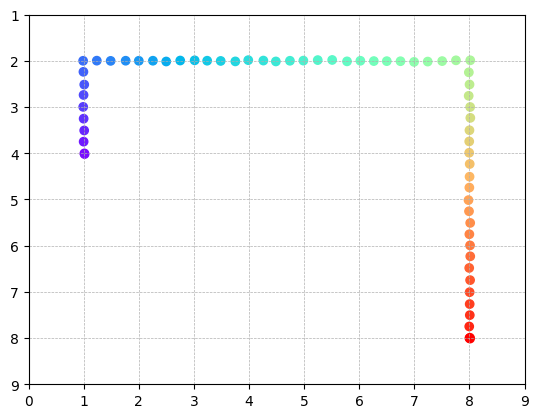

tensor([[[1.3903, 4.3514],
         [0.9924, 3.8083],
         [0.9615, 3.3259],
         [0.7645, 3.4674],
         [1.3840, 3.1610],
         [0.9864, 2.8511],
         [0.7909, 2.8034],
         [1.2264, 2.3839],
         [1.0840, 2.4044],
         [0.6311, 1.8500],
         [0.8555, 2.0669],
         [1.8796, 2.0918],
         [1.7945, 2.2726],
         [2.2568, 1.8068],
         [2.0883, 1.8507],
         [2.4374, 1.9645],
         [2.5740, 1.7242],
         [3.0161, 1.8759],
         [3.2488, 1.7974],
         [3.4457, 1.8075],
         [3.1620, 1.9471],
         [4.2706, 2.0351],
         [4.6008, 1.9680],
         [4.2418, 1.9106],
         [4.5946, 1.9178],
         [4.4555, 1.6151],
         [5.1114, 1.9954],
         [5.1760, 2.0727],
         [5.5534, 1.4874],
         [5.8730, 1.9747],
         [6.1180, 1.8520],
         [6.5010, 2.1626],
         [6.3337, 2.7109],
         [6.8447, 2.1130],
         [7.1677, 2.0954],
         [7.1841, 1.9402],
         [8.0840, 1.7902],
 

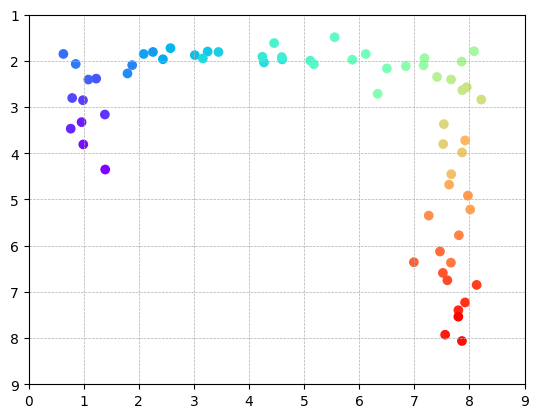

tensor([[[1.3946, 4.1639],
         [0.5256, 3.2008],
         [0.3734, 2.6623],
         [0.8262, 3.7027],
         [0.4650, 2.5189],
         [0.7744, 2.6539],
         [1.2250, 2.2193],
         [0.4784, 2.5545],
         [0.2815, 1.8216],
         [0.9853, 1.1558],
         [0.8764, 1.0400],
         [0.8897, 2.5224],
         [1.4638, 1.9448],
         [1.9064, 2.1145],
         [1.7583, 1.7590],
         [2.2135, 0.7525],
         [1.9287, 1.5960],
         [1.7835, 1.3605],
         [2.4229, 2.2307],
         [2.8210, 1.4666],
         [3.4828, 1.5208],
         [3.3497, 2.4783],
         [3.4740, 2.7508],
         [3.6876, 1.4491],
         [3.0540, 1.9037],
         [4.6484, 2.6291],
         [4.4531, 2.3352],
         [5.1388, 1.7476],
         [5.2746, 1.2623],
         [5.1310, 1.3193],
         [5.7019, 1.6501],
         [5.8200, 2.2128],
         [6.1033, 1.9839],
         [6.4674, 1.8133],
         [5.9875, 1.4861],
         [6.5945, 2.1530],
         [6.8773, 1.3579],
 

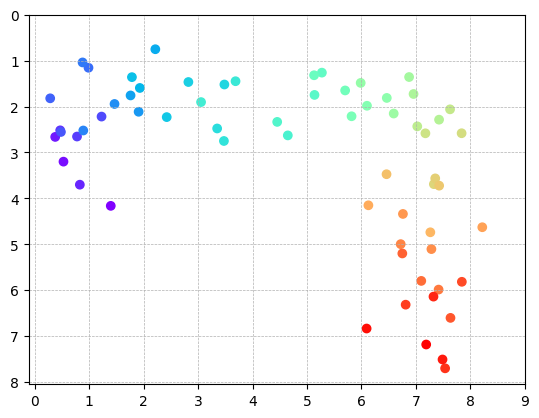

tensor([[[ 1.3832,  3.8811],
         [ 0.6511,  3.4962],
         [ 0.9550,  3.6889],
         [ 0.9646,  3.5923],
         [ 1.2313,  2.0349],
         [ 0.7279,  3.6137],
         [-0.0350,  0.7484],
         [ 0.6766,  2.4564],
         [ 1.3055,  1.1194],
         [ 1.4909,  1.3607],
         [ 1.2351,  2.2090],
         [ 2.1973,  1.8846],
         [ 1.9597,  2.1413],
         [ 2.3550,  2.2506],
         [ 2.7731,  1.9062],
         [ 1.3524,  2.1266],
         [ 2.5440,  0.2368],
         [ 1.9179,  0.7691],
         [ 3.7559,  1.3265],
         [ 3.6722,  0.7920],
         [ 2.5437,  1.8867],
         [ 2.5682,  1.8125],
         [ 4.3742,  1.0722],
         [ 2.8370,  1.5904],
         [ 3.5633,  0.8091],
         [ 5.0101,  1.7142],
         [ 4.0377,  2.7321],
         [ 3.8472,  1.9682],
         [ 4.6813,  1.8037],
         [ 4.1127,  1.8204],
         [ 5.4105,  1.3861],
         [ 4.6703,  2.9604],
         [ 6.2915,  1.8400],
         [ 6.1914,  1.5288],
         [ 5.1

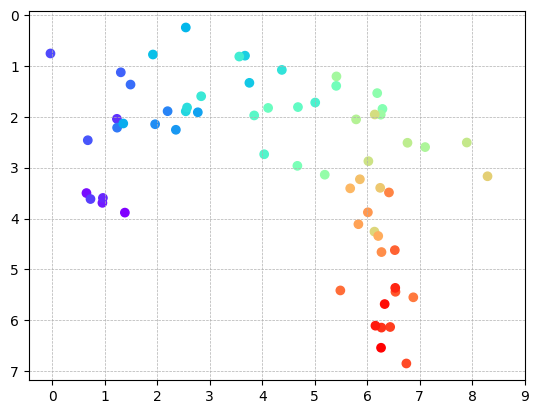

tensor([[[-8.2841e-02,  5.8342e-01],
         [ 6.4304e-01,  2.1285e+00],
         [ 1.3760e+00, -5.3579e-01],
         [-2.5062e-04,  3.5077e-01],
         [-7.4808e-01,  1.5086e+00],
         [ 6.8050e-01, -6.3403e-02],
         [ 6.2509e-01,  4.2008e-01],
         [ 3.7073e-01, -5.8249e-01],
         [ 2.2149e-01,  8.5494e-01],
         [-1.6612e+00,  5.0894e-01],
         [ 7.3680e-01,  8.8365e-01],
         [ 8.5120e-01, -3.9249e-01],
         [ 5.9335e-01,  1.2457e+00],
         [ 4.9566e-01, -1.0448e+00],
         [-3.7737e-01,  2.1434e-02],
         [ 1.6232e+00,  2.3495e+00],
         [-1.1125e+00,  1.8534e+00],
         [ 1.4040e+00,  1.8320e+00],
         [ 1.2318e+00,  1.4708e-01],
         [ 7.2078e-01, -8.0275e-01],
         [ 1.5041e+00,  1.2971e+00],
         [-5.8314e-01, -1.2159e+00],
         [ 2.3196e+00,  6.3571e-01],
         [ 2.7938e-01,  1.7056e+00],
         [-1.5329e-01,  1.1886e+00],
         [ 9.8669e-01,  6.1306e-01],
         [ 3.4957e-01,  3.6589e-01],
 

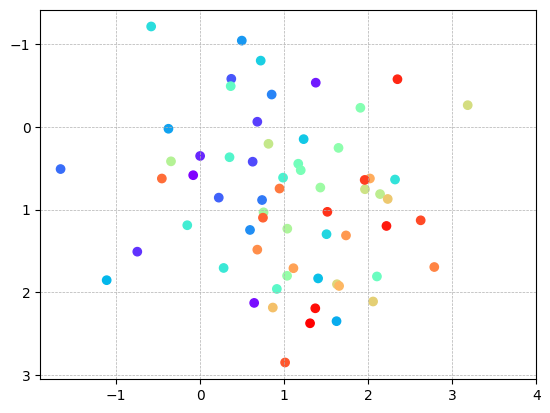

tensor([[[-1.2662,  1.2350],
         [-1.0484,  0.5465],
         [ 2.2568,  1.6248],
         [-0.4851, -1.8153],
         [ 0.4370, -0.0325],
         [ 1.3767, -0.0788],
         [-0.4023,  0.1674],
         [ 0.6547, -0.7971],
         [-0.0253,  0.5806],
         [ 0.9316,  1.6355],
         [ 0.4850,  1.7315],
         [ 0.7916,  0.6997],
         [-0.0064, -0.3935],
         [-1.5698, -1.1922],
         [ 0.0101, -0.1371],
         [-0.7493, -0.5017],
         [ 1.6751,  0.0115],
         [-0.9004, -0.4460],
         [ 0.5977, -1.0015],
         [ 1.1681, -0.4054],
         [-1.4453, -2.5476],
         [ 0.3073,  1.2694],
         [ 0.4076, -1.1116],
         [-0.6595,  0.2965],
         [-0.1303,  1.9233],
         [ 0.2170, -0.1387],
         [ 2.3576,  0.4718],
         [ 1.1122,  1.7722],
         [-0.6692, -0.0984],
         [ 0.1100,  0.0972],
         [ 1.0613,  0.6025],
         [ 0.8293,  3.3967],
         [ 1.1765, -0.7397],
         [ 1.8058, -0.0090],
         [ 0.1

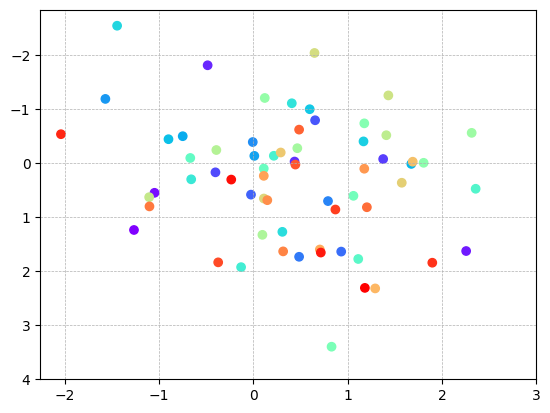

In [247]:
# plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])
from utils.get_trajectories import visualize_trajectory
# normalize the x_start by the size of the maze which is 8
print(x_start)
# x_start_normalized = x_start / 8
# print(torch.mean(x_start_normalized))
# print(torch.std(x_start_normalized))
# # make them in range [-1, 1]
# x_start_normalized = (x_start_normalized * 2) - 1
# print(x_start_normalized)

for t in [0, 50, 100, 150, 400, 499]:
  x_noisy = get_noisy_image(x_start, torch.tensor([t]))
  print(x_noisy)
    # print the mean and std of the noisy image
    # print(torch.mean(x_noisy))
    # print(torch.std(x_noisy))
  visualize_trajectory(x_noisy)

In [248]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1", condition=None):
    if noise is None:
        noise = torch.randn_like(x_start)
        
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    # print("x_noisy", x_noisy.shape)
    predicted_noise = denoise_model(x_noisy, t, global_cond=condition)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [249]:
@torch.no_grad()
def p_sample(model, x, t, t_index, global_cond=None):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, global_cond) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape, global_cond=None):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i, global_cond=global_cond)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

@torch.no_grad()
def sample_trajectories(model, traj_size, batch_size=16, output_dim = 2, global_cond=None):
    return p_sample_loop(model, shape=(batch_size, traj_size, output_dim), global_cond=global_cond)


Note that the code above is a simplified version of the original implementation. We found our simplification (which is in line with Algorithm 2 in the paper) to work just as well as the [original, more complex implementation](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/diffusion_utils.py).


## Train the model

Next, we train the model in regular PyTorch fashion. We also define some logic to peridiocally save generated images, using the `sample` method defined above.


In [250]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

Below, we define the model, and move it to the GPU. We also define a standard optimizer (Adam).

In [251]:
# Taken from https://diffusion-policy.cs.columbia.edu/
import logging
import math
from typing import List, Optional, Tuple, Union
import typing

import torch
from torch import nn

# @markdown ### **Network**
# @markdown
# @markdown Defines a 1D UNet architecture `ConditionalUnet1D`
# @markdown as the noies prediction network
# @markdown
# @markdown Components
# @markdown - `SinusoidalPosEmb` Positional encoding for the diffusion iteration k
# @markdown - `Downsample1d` Strided convolution to reduce temporal resolution
# @markdown - `Upsample1d` Transposed convolution to increase temporal resolution
# @markdown - `Conv1dBlock` Conv1d --> GroupNorm --> Mish
# @markdown - `ConditionalResidualBlock1D` Takes two inputs `x` and `cond`. \
# @markdown `x` is passed through 2 `Conv1dBlock` stacked together with residual connection.
# @markdown `cond` is applied to `x` with [FiLM](https://arxiv.org/abs/1709.07871) conditioning.


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        # print('emb shape:', emb.shape)
        return emb


class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Conv1dBlock(nn.Module):
    """
    Conv1d --> GroupNorm --> Mish
    """

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


class ConditionalResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim, kernel_size=3, n_groups=8):
        super().__init__()

        self.blocks = nn.ModuleList(
            [
                Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups,),
                Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups,),
            ]
        )

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(), nn.Linear(cond_dim, cond_channels,), nn.Unflatten(-1, (-1, 1))
        )

        # make sure dimensions compatible
        self.residual_conv = (
            nn.Conv1d(in_channels, out_channels, 1,)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, cond):
        """
        x : [ batch_size x in_channels x horizon ]
        cond : [ batch_size x cond_dim]

        returns:
        out : [ batch_size x out_channels x horizon ]
        """
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:, 0, ...]
        bias = embed[:, 1, ...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out


class ConditionalUnet1D(nn.Module):
    def __init__(
        self,
        input_dim: int,
        global_cond_dim: int,
        down_dims: List[int],
        diffusion_step_embed_dim: int,
        kernel_size: int = 5,
        n_groups: int = 8,
    ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines number of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList(
            [
                ConditionalResidualBlock1D(
                    mid_dim,
                    mid_dim,
                    cond_dim=cond_dim,
                    kernel_size=kernel_size,
                    n_groups=n_groups,
                ),
                ConditionalResidualBlock1D(
                    mid_dim,
                    mid_dim,
                    cond_dim=cond_dim,
                    kernel_size=kernel_size,
                    n_groups=n_groups,
                ),
            ]
        )

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(
                nn.ModuleList(
                    [
                        ConditionalResidualBlock1D(
                            dim_in,
                            dim_out,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        ConditionalResidualBlock1D(
                            dim_out,
                            dim_out,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        Downsample1d(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(
                nn.ModuleList(
                    [
                        ConditionalResidualBlock1D(
                            dim_out * 2,
                            dim_in,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        ConditionalResidualBlock1D(
                            dim_in,
                            dim_in,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        Upsample1d(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size, n_groups=n_groups),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

    def forward(
        self,
        sample: torch.Tensor,
        timestep: torch.Tensor,
        global_cond: Optional[torch.Tensor] = None,
    ):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B, global_cond_dim)
        output: (B,T,input_dim)
        """
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

        # (B,T,C)
        sample = sample.moveaxis(-1, -2)
        # print('sample shape:', sample.shape)

        # 1. time
        timesteps = timestep
        if timesteps.shape == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])
        timesteps = timesteps.to(sample.device)

        global_feature = self.diffusion_step_encoder(timesteps)
        global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)

        if global_cond is not None:
            global_feature = torch.cat([global_feature, global_cond], axis=-1)

        x = sample
        h = []
        # print('downsampling')
        for resnet, resnet2, downsample in self.down_modules:
            # print('x shape:', x.shape)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            # print('h shape:', h[-1].shape)
            x = downsample(x)


        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)
        # print('upsampling')
        for resnet, resnet2, upsample in self.up_modules:
            # print('x shape:', x.shape)
            # print('h shape:', h[-1].shape)
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)
        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1, -2)
        # (B,T,C)
        return x

In [252]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
# trajectories = trajectories[0:32]
trajectories = trajectories[:50]
trajectories_size = trajectories.shape
print(trajectories_size)
# model = Unet(
#     dim=trajectories_size[1],
#     channels=channels,
#     dim_mults=(1, 2, 4,)
# )
# TODO: double check down_dims
model = ConditionalUnet1D(
    input_dim=2,
    # global_cond_dim=0,
    global_cond_dim=4,
    down_dims=[16, 32, 64],
    diffusion_step_embed_dim=trajectories_size[1],
    kernel_size=3,
    n_groups=1,
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

torch.Size([50, 64, 2])


Let's start training!

In [253]:
# print the total number of trajectories
print(trajectories.shape)


torch.Size([50, 64, 2])


In [257]:
from torchvision.utils import save_image
from torch.utils.data import DataLoader

epochs = 300
batch_size = 32
# channels = 1
dataloader = DataLoader(trajectories, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
   loss_arr = []
   for step, batch in enumerate(dataloader):
      optimizer.zero_grad()
      
      
      b = batch.shape[0]
      batch = batch.to(device)
      # batch shape: (B, T, C)
      # print('input shape pre reshape', batch.shape)

      # batch = batch.reshape(b, channels, batch.shape[1], batch.shape[2])
      
      # normalize the batch to [-1, 1]
      batch = (batch / 8) * 2 - 1
      
      # generate conditioning based on start and end states
      start_states = batch[:, 0, :]
      end_states = batch[:, -1, :]
      condition = torch.cat((start_states, end_states), axis=1)
      # print(condition)
      # condition = None
      # print('condition shape', condition.shape)
      
      # print("batch: ", torch.mean(batch[4]), torch.std(batch[4]))
      # print("Max and min", torch.max(batch[4]), torch.min(batch[4]))

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()
      if b != batch_size:
         continue
      loss = p_losses(model, batch, t, loss_type="huber", condition=condition)

      # if step % 100 == 0:
      # print("Loss:", loss.item())
      
      loss_arr.append(loss.item())

      loss.backward()
      optimizer.step()
   print(f"Loss for epoch {epoch}: {np.mean(loss_arr)}")
      # save generated images
      # if step != 0 and step % save_and_sample_every == 0:
      #   milestone = step // save_and_sample_every
      #   batches = num_to_groups(4, batch_size)
      #   all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
      #   all_images = torch.cat(all_images_list, dim=0)
      #   all_images = (all_images + 1) * 0.5
      #   save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

/tmp/ipykernel_1282385/397776207.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)


Loss for epoch 0: 0.008008414879441261
Loss for epoch 1: 0.011610126122832298
Loss for epoch 2: 0.00940636359155178
Loss for epoch 3: 0.01344144158065319
Loss for epoch 4: 0.0070496369153261185
Loss for epoch 5: 0.008663786575198174
Loss for epoch 6: 0.009314973838627338
Loss for epoch 7: 0.014577392488718033
Loss for epoch 8: 0.01851477101445198
Loss for epoch 9: 0.010014759376645088
Loss for epoch 10: 0.01014314778149128
Loss for epoch 11: 0.011349816806614399
Loss for epoch 12: 0.01561257429420948
Loss for epoch 13: 0.00692645413801074
Loss for epoch 14: 0.008104252628982067
Loss for epoch 15: 0.006900636479258537
Loss for epoch 16: 0.016195891425013542
Loss for epoch 17: 0.009821701794862747
Loss for epoch 18: 0.01095578633248806
Loss for epoch 19: 0.004999931901693344
Loss for epoch 20: 0.00858712662011385
Loss for epoch 21: 0.016215898096561432
Loss for epoch 22: 0.008655766025185585
Loss for epoch 23: 0.007756704464554787
Loss for epoch 24: 0.007334006950259209
Loss for epoch 25

## Sampling (inference)

To sample from the model, we can just use our sample function defined above:


In [260]:
global_cond = torch.tensor([2, 2, 7, 4]).unsqueeze(0).to(device)
# convert condition to [-1, 1]
global_cond = (global_cond / 8) * 2 - 1
# print(global_cond)
# global_cond = None
samples = sample_trajectories(model=model, traj_size=64, batch_size=1, output_dim=2, global_cond=global_cond)
print(len(samples))

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_1282385/397776207.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)
sampling loop time step: 100%|██████████| 500/500 [00:02<00:00, 241.66it/s]

500


(1, 64, 2)
[[[ 2.8344908  -0.68739414]
  [ 6.8053656   5.5322    ]
  [ 7.050277    7.28773   ]
  [ 4.7356334   7.402214  ]
  [ 6.9012947   0.8583331 ]
  [ 5.8097315   4.828597  ]
  [-2.9126906   1.5724502 ]
  [ 8.278282    2.8011894 ]
  [ 9.8491745  11.79501   ]
  [ 5.3057303   2.3224697 ]
  [ 4.859405    5.429757  ]
  [ 3.4399357   1.4019275 ]
  [ 1.1333942   1.9370551 ]
  [ 5.2639318   3.2298086 ]
  [ 1.5933235   9.044498  ]
  [ 5.1063786   7.851782  ]
  [ 4.7847576   3.5822785 ]
  [-0.55586815  2.2944865 ]
  [-1.4410954  -1.166729  ]
  [-0.25151825  4.7070303 ]
  [ 1.4757819   0.24200678]
  [ 7.6202717   0.38556147]
  [ 0.21270108  7.007406  ]
  [ 0.97505355  9.078655  ]
  [11.461318   -1.7547684 ]
  [ 3.016427    7.38205   ]
  [-6.7250957   2.2630985 ]
  [ 5.6480193   0.5751209 ]
  [ 1.4703948   2.7872822 ]
  [ 4.130806    8.654136  ]
  [ 0.37718534  1.8509302 ]
  [ 1.4230864   4.401387  ]
  [ 3.307725   11.991631  ]
  [-2.1565294   6.500517  ]
  [-5.793746    7.277359  ]
  [ 3.519

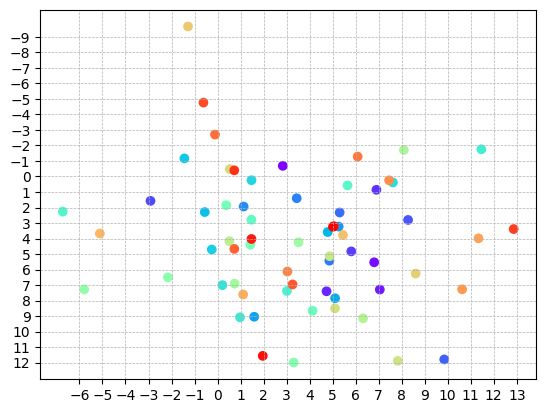

(1, 64, 2)
[[[ 9.0139418e+00 -1.3925714e+00]
  [ 3.4520972e+00  4.2398944e+00]
  [ 6.4023485e+00  8.6075478e+00]
  [ 5.0136027e+00  9.1984596e+00]
  [ 8.0177889e+00  4.5579157e+00]
  [ 7.9775643e+00  1.3360736e+00]
  [ 7.1922064e-01  4.6122479e-01]
  [ 6.3917122e+00  6.4427128e+00]
  [ 4.8473783e+00  6.9628105e+00]
  [ 2.5144184e+00  5.6811213e+00]
  [ 3.7923334e+00  5.6242886e+00]
  [ 7.8119125e+00 -1.3132582e+00]
  [ 3.8691478e+00  6.9051957e-01]
  [ 3.1224685e+00 -5.0999899e+00]
  [ 7.4061317e+00  9.1330109e+00]
  [ 3.8628705e+00  1.0825990e+01]
  [ 4.8494115e+00  7.0250034e-03]
  [-8.5327997e+00 -1.7151990e+00]
  [ 1.5504835e+00 -1.4353456e+00]
  [-1.7027993e+00  6.8398614e+00]
  [ 2.6920266e+00  8.4241796e-01]
  [ 1.0576715e+01 -5.4496164e+00]
  [ 8.2709789e+00  6.2132182e+00]
  [ 6.4270210e-01  9.1455383e+00]
  [ 1.2465588e+01 -2.6904583e-01]
  [-2.8768559e+00  1.9179940e+00]
  [-7.8507872e+00  3.6476946e+00]
  [ 5.5234556e+00  3.4505258e+00]
  [ 3.8785770e+00  8.0441070e-01]
  [

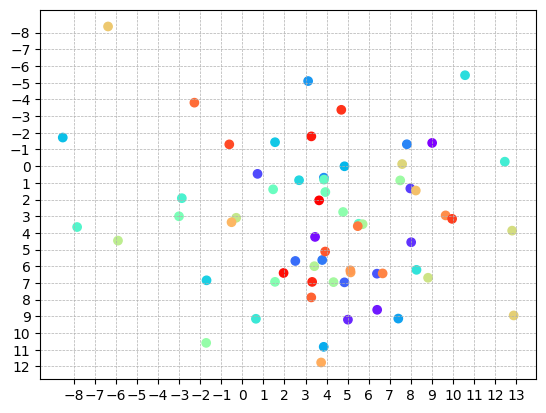

(1, 64, 2)
[[[  5.8469253   -5.0962687 ]
  [  2.0348697    2.7806726 ]
  [  5.784404     9.64668   ]
  [  5.4734306   14.4721    ]
  [  0.64030695   6.6711674 ]
  [  8.849947     2.1270492 ]
  [ -2.4781542   -3.5784369 ]
  [  8.067617     9.168479  ]
  [  4.018361     4.2563243 ]
  [  3.252307     1.6586359 ]
  [  6.8791485    2.4438667 ]
  [ 11.506641    -3.4081883 ]
  [ -1.3453965    2.0841186 ]
  [  6.8397746   -5.9395494 ]
  [  3.772605     9.006636  ]
  [  2.2962453    5.014302  ]
  [  8.776819     1.5685191 ]
  [ -4.3003263    0.6774695 ]
  [  2.580627    -0.48079348]
  [ -1.9297867    5.7741704 ]
  [  7.7583427    2.3466468 ]
  [ 11.677228    -4.070616  ]
  [ 10.81255      5.09629   ]
  [  5.6671367    7.039162  ]
  [  5.47056     -6.845948  ]
  [ -0.41448736   6.770385  ]
  [  3.1630316    2.3063693 ]
  [  8.955896     5.8145046 ]
  [  4.0790434   -4.4964876 ]
  [ -4.7322187    5.588141  ]
  [  9.733324     2.2333126 ]
  [ -8.199917     5.623741  ]
  [  3.102273     7.85435   ]

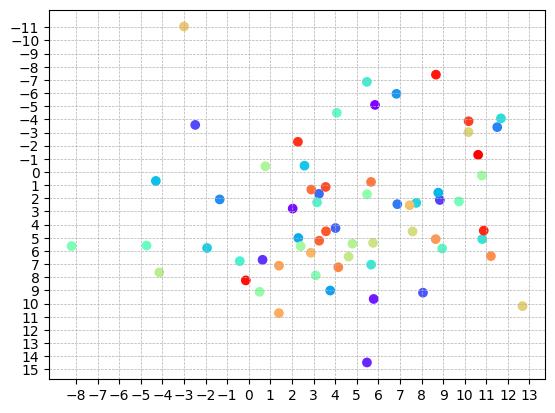

(1, 64, 2)
[[[ 1.3916655  -0.47210455]
  [-1.4878864   1.565309  ]
  [ 6.9489794   9.702358  ]
  [ 0.93408656  6.199255  ]
  [-1.9305229   2.4135873 ]
  [ 0.87745214 -1.6799955 ]
  [ 6.8701534   1.3510818 ]
  [ 7.005295    5.929781  ]
  [ 2.4998662   2.4072533 ]
  [-3.6067271   2.190739  ]
  [ 7.3418484  -0.3377819 ]
  [10.463807    0.5189333 ]
  [-1.3700504  -7.1963882 ]
  [ 9.530823   -1.4085903 ]
  [ 3.7905962   8.435774  ]
  [ 3.8208294   7.4176054 ]
  [ 0.3735106   6.8400803 ]
  [-0.68894815 -2.6412778 ]
  [ 0.64256954 -3.660037  ]
  [ 0.5992706   1.1058884 ]
  [ 9.219925    5.2663326 ]
  [ 8.136345    0.92157674]
  [ 6.390111    4.368782  ]
  [ 7.6079416   1.7623286 ]
  [ 6.4526043  -2.1648068 ]
  [-0.67882395  1.6554623 ]
  [ 9.8018      3.5561652 ]
  [ 7.916822    6.7671156 ]
  [ 7.5038185  -4.088251  ]
  [ 0.23219371  4.738956  ]
  [ 9.7928705  -0.0166769 ]
  [ 0.16651154  4.83911   ]
  [ 2.6242936   2.4906504 ]
  [ 6.2574906   3.9673755 ]
  [ 3.059012    2.347375  ]
  [ 6.114

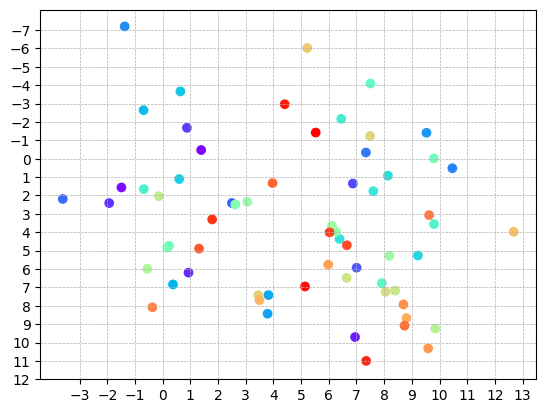

(1, 64, 2)
[[[ 1.5645609   3.0617118 ]
  [ 3.4072804   4.5103455 ]
  [ 0.84155893  5.1895437 ]
  [ 1.1173439   5.821377  ]
  [ 4.6579      3.234626  ]
  [ 0.63557076  3.162386  ]
  [ 2.3486767   0.8874829 ]
  [ 1.6901388   2.281952  ]
  [ 3.3423254   3.1543472 ]
  [-0.9542804   4.070551  ]
  [ 4.16409     2.224711  ]
  [ 0.02729988  2.8054886 ]
  [ 2.5128403   0.9785609 ]
  [ 3.7316878   2.795622  ]
  [ 1.4426053   3.780454  ]
  [ 1.5329134   3.4637809 ]
  [ 1.7752671   3.5222788 ]
  [ 1.1427491   3.3276381 ]
  [-1.4882822  -0.73940754]
  [-0.22929955  2.2094111 ]
  [ 1.0465701   4.3899307 ]
  [ 1.0929785   3.4294019 ]
  [ 2.3975482   4.9383583 ]
  [ 0.15884829  6.2098703 ]
  [ 0.9354191   3.836855  ]
  [-0.16167784  7.6942954 ]
  [ 3.10682     5.431666  ]
  [ 2.1074033   7.1147556 ]
  [ 1.9398308   0.8936453 ]
  [ 1.1672626   4.0601764 ]
  [-0.16349888  2.0605621 ]
  [ 2.5400515   5.564516  ]
  [ 1.8013849   5.044243  ]
  [ 4.501576    3.7248638 ]
  [ 4.1015787   2.2662148 ]
  [ 2.617

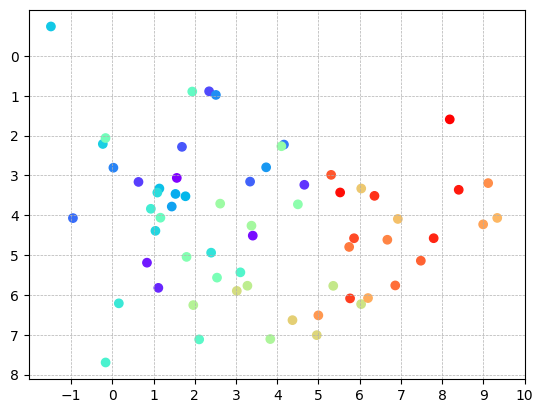

(1, 64, 2)
[[[1.9670193 2.3718972]
  [1.9569364 2.356187 ]
  [2.0033977 2.4848907]
  [1.9113855 2.5606966]
  [1.8682039 2.6501546]
  [1.7855365 2.6820145]
  [1.7217374 2.7420375]
  [1.6962781 2.8225412]
  [1.6558807 2.7516265]
  [1.6146967 2.7205234]
  [1.468951  2.6108627]
  [1.3766422 2.538973 ]
  [1.4210029 2.4877672]
  [1.4664512 2.4999313]
  [1.4697592 2.5384135]
  [1.4369678 2.5989466]
  [1.4189575 2.6701102]
  [1.3765879 2.8144588]
  [1.2752206 2.9754486]
  [1.2245286 3.1813798]
  [1.2474775 3.4495916]
  [1.2714365 3.7300384]
  [1.2739582 3.92799  ]
  [1.3417177 4.10588  ]
  [1.3840454 4.3414555]
  [1.5269322 4.536116 ]
  [1.7540226 4.7254095]
  [2.0182233 4.9362235]
  [2.3516593 5.0442095]
  [2.6396208 5.09139  ]
  [2.878098  5.122522 ]
  [3.1160817 5.1639924]
  [3.4419467 5.1832795]
  [3.797561  5.1487465]
  [4.146213  5.12504  ]
  [4.4642925 5.169825 ]
  [4.7658954 5.1222196]
  [5.0176477 5.075983 ]
  [5.3124256 5.070078 ]
  [5.5818086 5.0451417]
  [5.8365564 4.944533 ]
  [6.

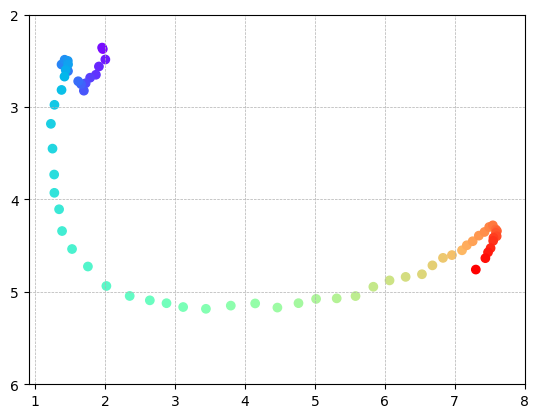

In [261]:
# show a random one
from utils.get_trajectories import visualize_trajectory
import numpy as np

# random_index = 180
# print(samples[random_index].shape)
# print(samples[random_index])
# random_sample = samples[random_index][0]
# print(np.mean(random_sample))
# print(np.std(random_sample))
# # plot the trajectory
# visualize_trajectory(random_sample)

# print the final trajectory
# samples[-1] = ((samples[-1]+1)/2) * 8 # denormalize
# print(samples[-1].shape)
# print(samples[-1])
# visualize_trajectory(samples[-1])


for i in [0, 50, 100, 200, 400, 499]:
  samples[i] = ((samples[i]+1)/2) * 8 # denormalize
  print(samples[i].shape)
  print(samples[i])
  visualize_trajectory(samples[i][:10])

<img src="https://drive.google.com/uc?id=1ytnzS7IW7ortC6ub85q7nud1IvXe2QTE" width="300" />